In [1]:
# All imports.
import torch
import numpy as onp
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
from functools import partial
from sklearn.metrics import balanced_accuracy_score
import torchvision.transforms.v2 as transforms
import copy


# Use notebook context for seaborn.
#sns.set_theme(context="notebook")


# Load MNIST data.
image_tensor, label_tensor = torch.load("mnist.pt")
image_array, label_array = image_tensor.numpy(), label_tensor.numpy()
num_images, height, width = image_array.shape


# Split into training, validation and test by famous 7/1/2.
# Just work on a single one fold.
indices, labels = onp.arange(len(label_array)), label_array
rest_indices, test_indices, rest_labels, test_labels = train_test_split(
    indices, labels,
    test_size=2 / (7 + 1 + 2), random_state=0, shuffle=True, stratify=labels,
)
train_indices, valid_indices, train_labels, valid_labels = train_test_split(
    rest_indices, rest_labels,
    test_size=1 / (7 + 1), random_state=0, shuffle=True, stratify=rest_labels,
)
train_image_array = image_array[train_indices]
train_label_array = label_array[train_indices]
valid_image_array = image_array[valid_indices]
valid_label_array = label_array[valid_indices]
test_image_array = image_array[test_indices]
test_label_array = label_array[test_indices]


# Augment test by rotations.
aug_image_buf = []
aug_label_buf = []
for degree in (0, 90, 180, 270):
    aug_image_buf.append(
        onp.rot90(
            test_image_array, degree // 90,
            axes=(1, 2),
        ),
    )
    aug_label_buf.append(test_label_array)
aug_test_image_array = onp.concatenate(
    aug_image_buf,
    axis=0,
)
aug_test_label_array = onp.concatenate(
    aug_label_buf,
    axis=0,
)


# Define 90-rotation function.
def rotate_array(array, degree):
    if (array.ndim == 2 and degree % 90 == 0):
        return onp.rot90(array, degree // 90)
    else:
        print("Can only rorate 2D array by 90n degrees.")
        raise RuntimeError


# Define average of 4 rotations (0, 90, 180, 270) function.
def averaged_four_rotations(array):
    buf = []
    for degree in (0, 90, 180, 270):
        buf.append(rotate_array(array, degree))
    return sum(buf) / len(buf)


# Define focusing label.
FOCUS_LABEL = 3
FIRST_TRAIN_FOCUS = onp.where(train_label_array == FOCUS_LABEL)[0][0]
FIRST_VALID_FOCUS = onp.where(valid_label_array == FOCUS_LABEL)[0][0]
FIRST_TEST_FOCUS = onp.where(test_label_array == FOCUS_LABEL)[0][0]


# # Render an image with four rotations as example.
# # Use pandas.DataFrame to fit for seaborn.
# render_table = {"Degree": [], "Image": []}
# example_image = image_array[FIRST_TRAIN_FOCUS]
# example_label = label_array[FIRST_TRAIN_FOCUS].item()
# for degree in (0, 90, 180, 270):
#     rotated_example_image = rotate_array(example_image, degree)
#     render_table["Degree"].append(degree)
#     render_table["Image"].append(rotated_example_image)
# render_frame = pd.DataFrame(render_table)
# grid = sns.FacetGrid(
#     render_frame,
#     col="Degree", col_wrap=2, hue="Degree",
# )
# grid.map(
#     lambda df, *args, **kwargs: sns.heatmap(
#         df.values[0],
#         cmap="gray", cbar=False, square=True,
#     ),
#     "Image",
# )
# for ax, degree in zip(grid.axes.flat, (0, 90, 180, 270)):
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     ax.set_title(
#         "Rotation Degree = {:d}$^\\circ$".format(degree),
#         fontdict=dict(fontsize=12),
#     )
# grid.fig.suptitle(
#     "Label = {:d}".format(example_label),
#     fontsize=16,
# )
# grid.tight_layout()
# grid.savefig("example_image.png")
# plt.close("all")

def showSubspace(subspace, Wshape, ndim=-1, channels=False):
    subspace = subspace.T

    if ndim == -1:
        ndim = subspace.shape[0]
    subspace = subspace[:ndim]

    ndim = subspace.shape[0]
    maxCols = min(ndim, 4)

    for j in range(ndim):
        if j % maxCols == 0:
            plt.show()
            nCols = maxCols if ndim - j > maxCols else ndim - j
            fig, axes = plt.subplots(1, nCols, figsize=(12 * nCols // 2, 9 // 2))
            try:
                axes[0]
            except:
                axes = [axes]

        kernel = subspace[j]
        kernel = kernel.reshape(*Wshape)

        if len(kernel.shape) == 3:
            kernel = kernel.transpose(1, 2, 0)
            if channels:
                kernel = np.concatenate([kernel[:, :, c] for c in range(kernel.shape[-1])], axis=1)
                axes[j%maxCols].add_patch(patches.Rectangle((-0.45, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:red'))
                axes[j%maxCols].add_patch(patches.Rectangle((2.55, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:green'))
                axes[j%maxCols].add_patch(patches.Rectangle((5.55, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:blue'))

        axes[j%maxCols].imshow(kernel.round(decimals=6), cmap="Greys")
        axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)

    plt.show()



# Construct specified onehot for flattened image and apply rotation.
def transformed_onehot(onehot_loc, transform_func, shape):
    # Get flattened onehot.
    numel = onp.prod(shape)
    onehot = onp.zeros(numel)
    onehot[onehot_loc] = 1

    # Transform onehot with specific shape view and flatten back.
    transformed_vec = transform_func(onehot.reshape(*shape))
    return transformed_vec.reshape(numel)


# Define number of CPUs to use for subspace generation.
NUM_TRANSFORM_CPUS = 12


# Apply given transformation on onehot corresponding to each pixel of 2D image.
# Use Python multiprocessing since it is work with numpy array.
# If it is torch Tensor, it is recommended to use PyTorch wrapped version of
# multiprocessing (torch.multiprocessing).
def get_invariant_subspace(transform_func, shape):
    # Use multiprocessing to get transformation matrix correspond to given
    # transformation function by paralleling onehot dimensions.
    numel = onp.prod(shape)
    pool = mp.Pool(NUM_TRANSFORM_CPUS)
    transformed_buf = pool.map(
        partial(
            transformed_onehot,
            transform_func=transform_func, shape=shape,
        ),
        range(numel),
    )
    pool.close()
    pool.join()
    transform_mat = onp.stack(
        transformed_buf,
        axis=1,
    )

    # Eigenvectors is used to describe the transformation subspace.
    # Use right side of decomposition thus eigenvectors are located at rows.
    # Transformation matrix is assumed to be real symmetric, thus Hermitian is
    # used for optimization.
    _, eigenvalues, eigenvectors = onp.linalg.svd(
        transform_mat,
        hermitian=True,
    )

    # Eigenvalues are sorted from high to low, thus for over rank eigenvectors,
    # they are null eigenvectors assigned with 0 eigenvalues.
    # We should focus on non-trival eigenvectors.
    rank = onp.linalg.matrix_rank(
        onp.diag(eigenvalues),
        hermitian=True,
    )
    ntri_eigenvectors = eigenvectors[:rank]
    null_eigenvectors = eigenvectors[rank:]
    return transform_mat, ntri_eigenvectors.T, null_eigenvectors.T, eigenvalues



# Define the test.
def accuracy(model, input, target):
    output = model.forward(input)
    _, predict = torch.max(
        output,
        dim=1,
    )
    return balanced_accuracy_score(
        y_true=target.tolist(), y_pred=predict.tolist(),
    )


# Prepare tensors.
train_input = torch.from_numpy(train_image_array).float()
train_input = train_input.view(len(train_label_array), height * width)
train_target = torch.from_numpy(train_label_array).long()
valid_input = torch.from_numpy(valid_image_array).float()
valid_input = valid_input.view(len(valid_label_array), height * width)
valid_target = torch.from_numpy(valid_label_array).long()
test_input = torch.from_numpy(test_image_array).float()
test_input = test_input.view(len(test_label_array), height * width)
test_target = torch.from_numpy(test_label_array).long()
aug_test_input = torch.from_numpy(aug_test_image_array).float()
aug_test_input = aug_test_input.view(len(aug_test_label_array), height * width)
aug_test_target = torch.from_numpy(aug_test_label_array).long()


# Global training settings.
BATCH_SIZE = 128
LR = 1e-3
WDECAY = 5e-5
NUM_EPOCHS = 100
NUM_BATCHES = len(train_input) // BATCH_SIZE
NUM_SAMPLES = NUM_BATCHES * BATCH_SIZE

In [2]:

train_input[0]

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4., 114., 192., 255.,
        253.,  56.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   

In [6]:
image = train_input[0].reshape(28, 28)

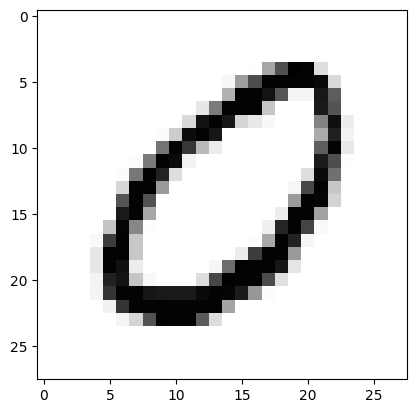

In [7]:
plt.imshow(image, cmap='Greys')
plt.show()

In [9]:
rot = transforms.functional.affine_image(image.unsqueeze(0), angle=-90, translate=(0,0), scale=1, shear=[0])

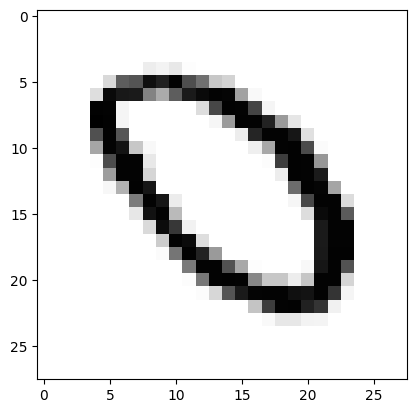

In [11]:
plt.imshow(rot.squeeze(0), cmap='Greys')
plt.show()